In [22]:
import tensorflow
import gym
import gym_anytrading
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [23]:
key_id = 'PK04UHV69AF2QULV4REU'
secret_key = '7g1qUN7qjsfW3U6oSccYYtHyQdoewJ12ANDQmSKd'
endpoint = 'https://paper-api.alpaca.markets'

In [24]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime


stock_client = StockHistoricalDataClient(key_id, secret_key)

# get 1 years worth data on Nvidia by the day. Could also use TimeFrame.Minute for daily data
request_params = StockBarsRequest(symbol_or_symbols=['NVDA'],
                                  timeframe=TimeFrame.Day,
                                  start=datetime(2020, 1, 1),
                                  end=datetime(2022, 1, 1)
                                  )

bars = stock_client.get_stock_bars(request_params)

In [25]:
data=bars.df.reset_index()
data.head()
df=data.iloc[:,1:]
df.head()

,timestamp,open,high,low,close,volume,trade_count,vwap
0,2020-01-02 05:00:00+00:00,238.85,239.91,236.720,239.91,5941969.0,67912.0,238.723319
1,2020-01-03 05:00:00+00:00,235.00,237.83,234.100,236.07,5145208.0,63605.0,236.384392
2,2020-01-06 05:00:00+00:00,232.36,237.27,231.270,237.06,6572812.0,73912.0,235.468778
3,2020-01-07 05:00:00+00:00,238.20,241.77,236.390,239.93,7980144.0,81624.0,239.855220
4,2020-01-08 05:00:00+00:00,239.76,242.04,238.149,240.38,6931017.0,70240.0,240.313148


In [26]:
from numpy import column_stack


df.rename(columns={"timestamp":"Date","close":'Close'},inplace=True)
df=df.iloc[:,:-2]
df.head(5)

,Date,open,high,low,Close,volume
0,2020-01-02 05:00:00+00:00,238.85,239.91,236.720,239.91,5941969.0
1,2020-01-03 05:00:00+00:00,235.00,237.83,234.100,236.07,5145208.0
2,2020-01-06 05:00:00+00:00,232.36,237.27,231.270,237.06,6572812.0
3,2020-01-07 05:00:00+00:00,238.20,241.77,236.390,239.93,7980144.0
4,2020-01-08 05:00:00+00:00,239.76,242.04,238.149,240.38,6931017.0


In [27]:
env = gym.make('stocks-v0',df=df,frame_bound=(10,100),window_size=5)
#env = gym.make('stocks-v0',frame_bound=(10,100),window_size=5)

info: {'total_reward': -28.31000000000003, 'total_profit': 0.6484048198439402, 'position': 0}


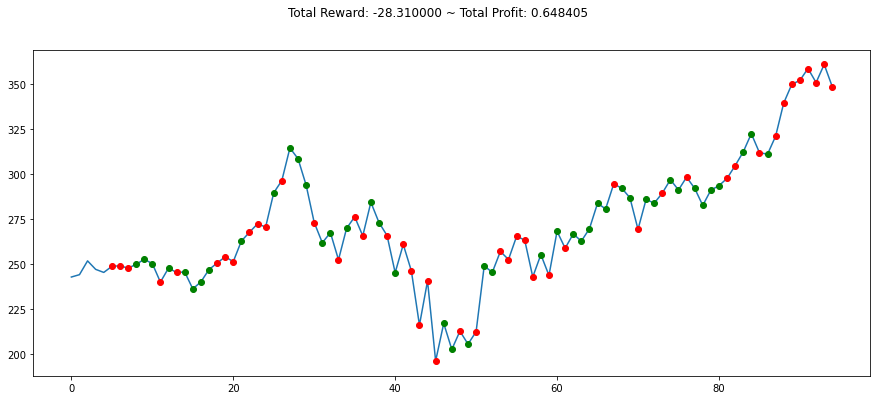

In [28]:
#Build Environment
state = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [29]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [30]:
df['SMA']=TA.SMA(df,12)
df["RSI"]=TA.RSI(df)
df['OBV']=TA.OBV(df)
df.fillna(0,inplace=True)
df.head(20)

,Date,open,high,low,Close,volume,SMA,RSI,OBV
0,2020-01-02 05:00:00+00:00,238.85,239.9100,236.7200,239.91,5941969.0,0.000000,0.000000,0.0
1,2020-01-03 05:00:00+00:00,235.00,237.8300,234.1000,236.07,5145208.0,0.000000,0.000000,-5145208.0
2,2020-01-06 05:00:00+00:00,232.36,237.2700,231.2700,237.06,6572812.0,0.000000,21.730950,1427604.0
3,2020-01-07 05:00:00+00:00,238.20,241.7700,236.3900,239.93,7980144.0,0.000000,53.367920,9407748.0
4,2020-01-08 05:00:00+00:00,239.76,242.0400,238.1490,240.38,6931017.0,0.000000,56.347335,16338765.0
5,2020-01-09 05:00:00+00:00,243.55,245.9297,240.8550,243.02,6386053.0,0.000000,68.900960,22724818.0
6,2020-01-10 05:00:00+00:00,247.48,248.5500,243.7500,244.32,7911560.0,0.000000,73.016122,30636378.0
7,2020-01-13 05:00:00+00:00,247.66,252.9884,246.7500,251.98,8008451.0,0.000000,85.332239,38644829.0
8,2020-01-14 05:00:00+00:00,250.51,251.2800,246.7500,247.28,8989483.0,0.000000,65.559779,29655346.0
9,2020-01-15 05:00:00+00:00,247.79,248.6891,244.5300,245.57,6577646.0,0.000000,60.103112,23077700.0


In [31]:
def add_signals(env):
    start = env.frame_bound[0]-env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'low'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['low','volume','SMA','RSI','OBV']].to_numpy()[start:end]
    return prices,signal_features

In [32]:
class MycustomEnv(StocksEnv):
    _process_data = add_signals

env2 = MycustomEnv(df=df,window_size=12,frame_bound=(12,50))

In [33]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [46]:
model = DQN('MlpPolicy',env,verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -21.8    |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 26194    |
|    time_elapsed     | 0        |
|    total_timesteps  | 148      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -10      |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 21673    |
|    time_elapsed     | 0        |
|    total_timesteps  | 296      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37       |
|    ep_rew_mean      | -7.5   

In [35]:
env = MycustomEnv(df=df,window_size=12,frame_bound=(12,50))
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 20.856100000000083, 'total_profit': 0.7900691168072733, 'position': 1}


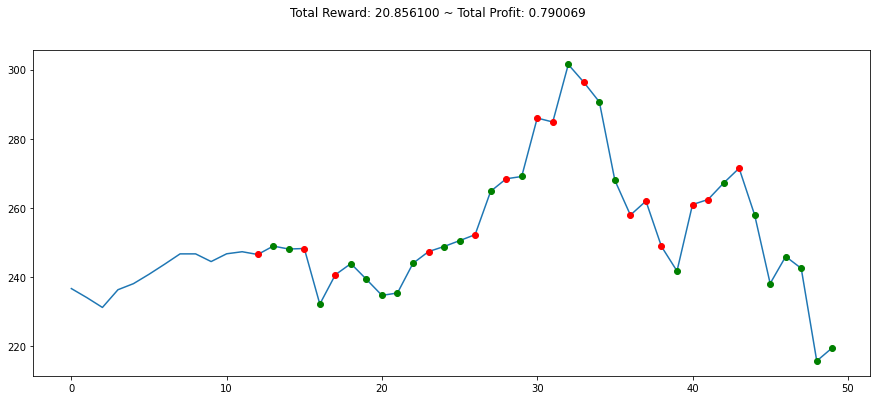

In [36]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [42]:

env_maker = lambda: gym.make('stocks-v0',df=df,frame_bound=(5,100),window_size=5)
env_ = DummyVecEnv([env_maker])


In [44]:
model = DQN('MlpPolicy',env_,verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 27783    |
|    time_elapsed     | 0        |
|    total_timesteps  | 376      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 26600    |
|    time_elapsed     | 0        |
|    total_timesteps  | 752      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.893    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 25769    |
|    time_elapsed     | 0        |
|    total_timesteps  | 1128     |
----------------------------------
----------------------------------
| r

In [39]:
env_ = gym.make('stocks-v0',df=df,frame_bound=(90,110),window_size=5)
observation = env_.reset()
while True:
    action = env_.action_space.sample()
    observation, reward, done, info = env_.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

info: {'total_reward': 19.5, 'total_profit': 1.0252705585837916, 'position': 1}


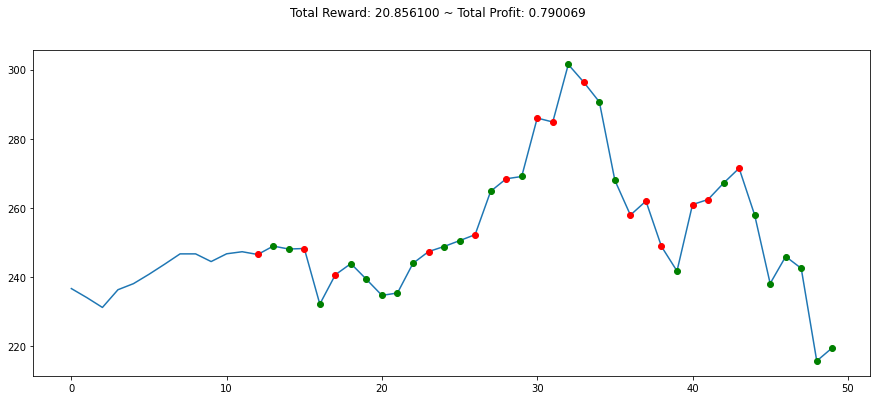

In [40]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()